# Imports

In [1]:
# PyABC imports
from pyabc import (ABCSMC, Distribution, RV,
                   History, MedianEpsilon)
from pyabc.populationstrategy import ConstantPopulationSize, AdaptivePopulationSize
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler

In [2]:
# Custom imports
from ionchannelABC import (ion_channel_sum_stats_calculator,
                           IonChannelAcceptor,
                           IonChannelDistance,
                           EfficientMultivariateNormalTransition,
                           plot_parameter_sensitivity,
                           plot_parameters_kde,
                           plot_sim_results,
                           plot_distance_weights)

INFO:myokit:Loading Myokit version 1.27.4


In [3]:
# Other necessary imports
import numpy as np
import subprocess
import pandas as pd
import io
import os
import tempfile

In [4]:
# Plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config Inline.Backend.figure_format = 'retina'

# Create ion channel model

In [5]:
from channels.ikr import ikr as model
#model.sample({})

# Get experimental measurements

In [6]:
measurements = model.get_experiment_data()
obs = measurements.to_dict()['y']
exp = measurements.to_dict()['exp']
errs = measurements.to_dict()['errs']

# Set limits and generate uniform initial priors

In [7]:
limits = dict(g_Kr=(0, 1),
              p1=(0, 1),
              p2=(0, 1),
              p3=(0, 1),
              p4=(0, 1),
              p5=(-1, 1),
              p6=(-1, 1),
              q1=(0, 1),
              q2=(-1, 1),
              q3=(0, 1.0),
              q4=(-0.5, 0.5),
              q5=(0, 0.01),
              q6=(-0.1, 0),
              k_f=(0, 1.0),
              k_b=(0, 1.0))
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# Test parameter sensitivity

In [9]:
parameters = ['ikr.'+k for k in limits.keys()]

In [10]:
distance_fn=IonChannelDistance(
    obs=obs,
    exp_map=exp,
    err_bars=errs,
    err_th=0.1)

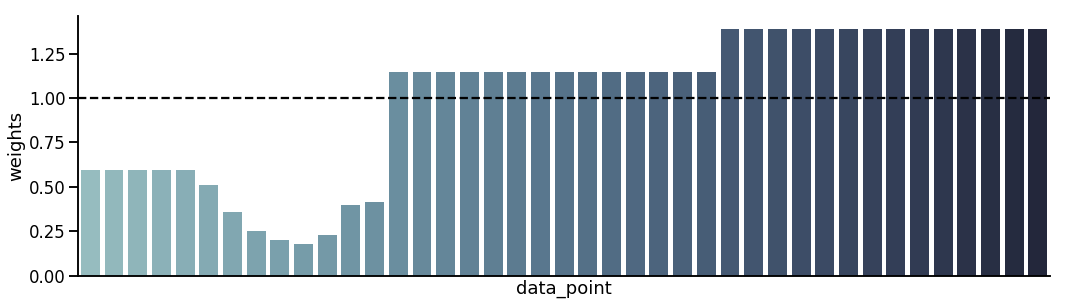

In [11]:
sns.set_context('talk')
g = plot_distance_weights(model, distance_fn)

In [12]:
g.savefig('results/ikr/dist_weights.pdf')

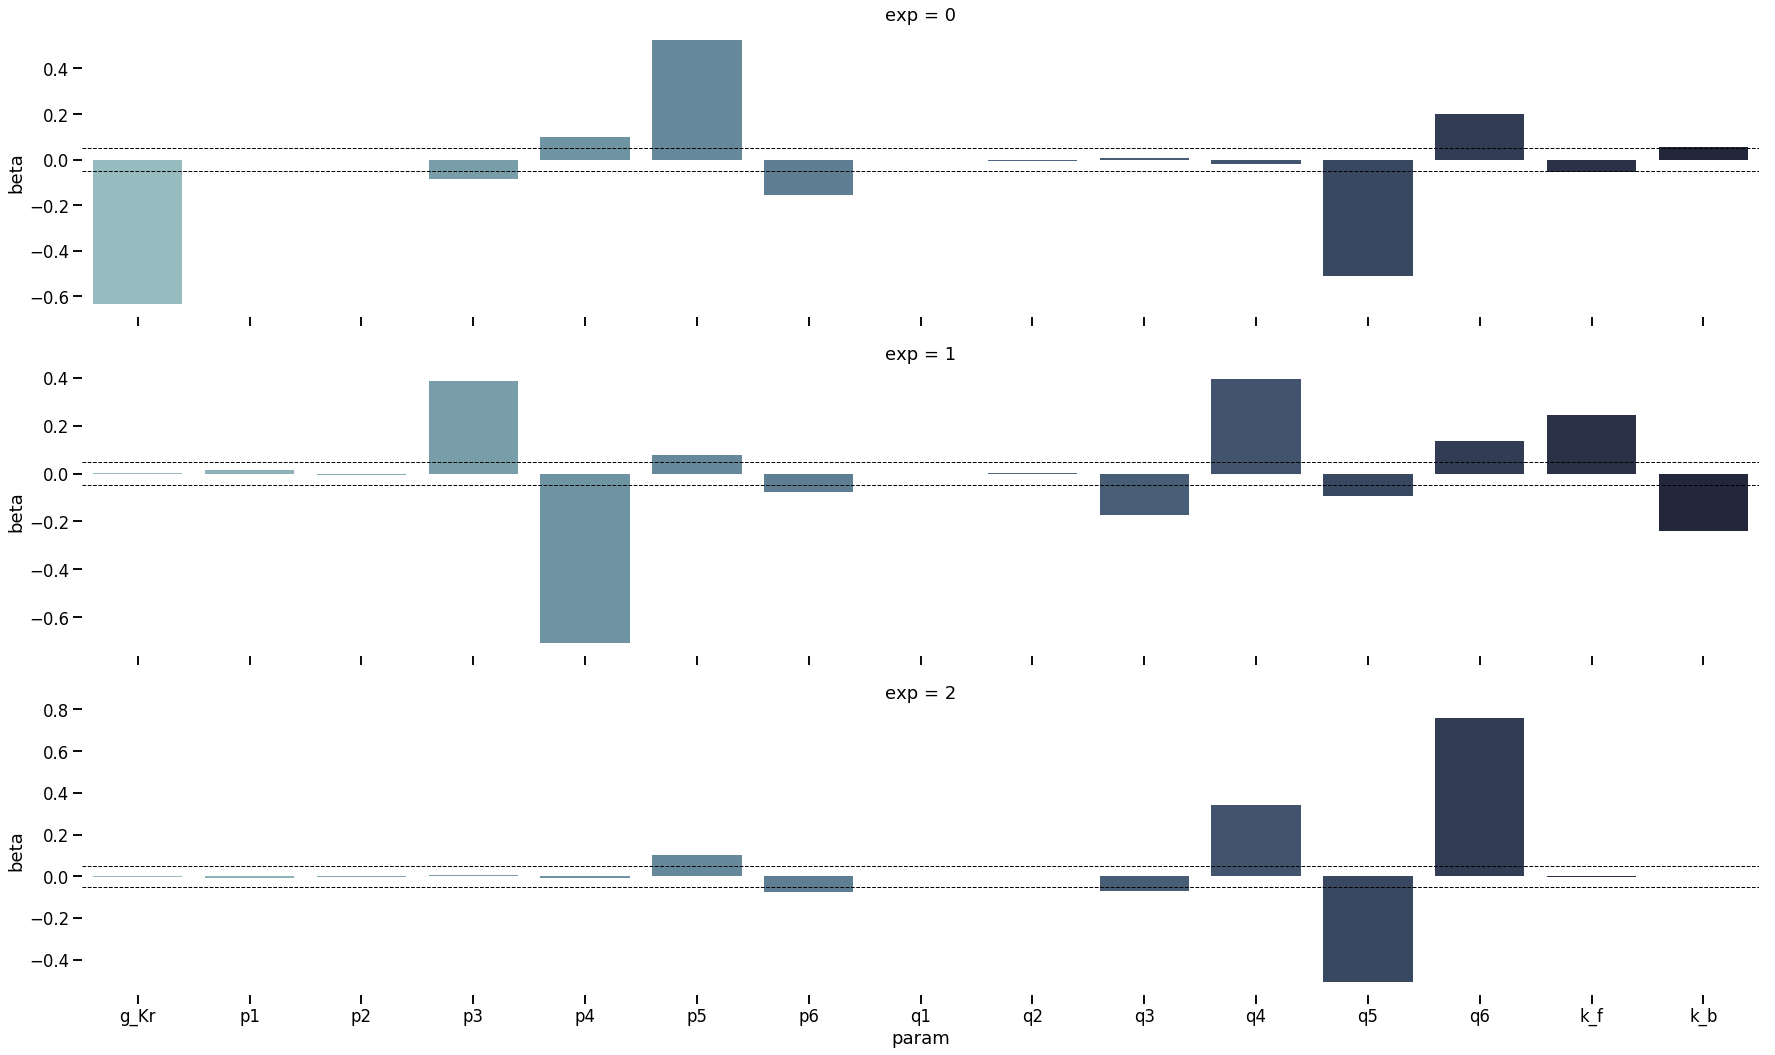

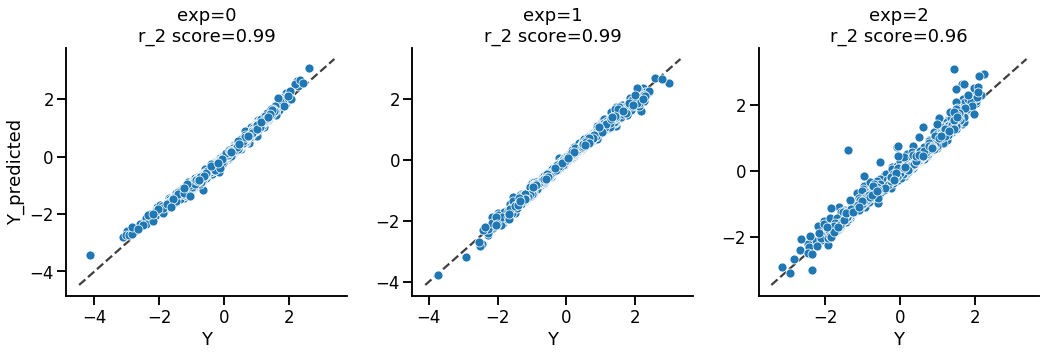

In [14]:
grid1, grid2 = plot_parameter_sensitivity(
    model,
    parameters,
    distance_fn,
    sigma=0.1,
    n_samples=1000,
    plot_cutoff=0.05)

In [15]:
grid1.savefig('results/ikr/sensitivity.pdf')
grid2.savefig('results/ikr/sensitivity_fit.pdf')

In [16]:
limits = dict(g_Kr=(0, 1),
              p3=(0, 1),
              p4=(0, 1),
              p5=(-1, 1),
              p6=(-1, 1),
              q3=(0, 1.0),
              q4=(-0.5, 0.5),
              q5=(0, 0.01),
              q6=(-0.1, 0),
              k_f=(0, 1.0),
              k_b=(0, 1.0))
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

# Initialise database

In [17]:
db_path = ('sqlite:///' + 
           os.path.join(tempfile.gettempdir(), "hl-1_ikr.db"))
print(db_path)

sqlite:////scratch/cph211/tmp/hl-1_ikr.db


In [18]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [19]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 obs=obs,
                 exp_map=exp,
                 err_bars=errs,
                 err_th=0.1),
             population_size=AdaptivePopulationSize(
                 start_nr_particles=5000,
                 mean_cv=0.4,
                 max_population_size=5000,
                 min_population_size=2500),
             summary_statistics=ion_channel_sum_stats_calculator,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(),
             sampler=MulticoreEvalParallelSampler(n_procs=12),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {0: 0.5919221782728408, 1: 0.5919221782728408, 2: 0.5919221782728408, 3: 0.5919221782728408, 4: 0.5919221782728408, 5: 0.5100615875134185, 6: 0.3589214085652413, 7: 0.24848770127006642, 8: 0.1998119181703408, 9: 0.17945880089709523, 10: 0.22802065955909487, 11: 0.39554604209230765, 12: 0.41238783920503586, 13: 1.1445070730392388, 14: 1.1445070730392388, 15: 1.1445070730392388, 16: 1.1445070730392388, 17: 1.1445070730392388, 18: 1.1445070730392388, 19: 1.1445070730392388, 20: 1.1445070730392388, 21: 1.1445070730392388, 22: 1.1445070730392388, 23: 1.1445070730392388, 24: 1.1445070730392388, 25: 1.1445070730392388, 26: 1.1445070730392388, 27: 1.3917567234867034, 28: 1.3917567234867034, 29: 1.3917567234867034, 30: 1.3917567234867034, 31: 1.3917567234867034, 32: 1.3917567234867034, 33: 1.3917567234867034, 34: 1.3917567234867034, 35: 1.3917567234867034, 36: 1.3917567234867034, 37: 1.3917567234867034, 38: 1.3917567234867034, 39: 1.3917567234867034, 40: 1.3917567

In [20]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2018-09-11 15:15:45.576312, end_time=None)>
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/epsilon.py:321: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances = weighted_distances.distance.as_matrix()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/epsilon.py:325: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  weights = weighted_distances.w.as_matrix()
INFO:Epsilon:initial epsilon is 8.420585273570689


In [33]:
history = abc.run(minimum_epsilon=0.05, max_nr_populations=10, min_acceptance_rate=0.005)

INFO:ABC:t:33 eps:1.0651694914548324
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/transition/multivariatenormal.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self._X_arr = X.as_matrix()
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/smc.py:735: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.history.max_t)["p"].as_matrix()
INFO:Adaptation:Change nr particles 5000 -> 5000
DEBUG:ABC:now submitting population 33
DEBUG:ABC:population 33 done
DEBUG:ABC:
total nr simulations up to t =33 is 7929170
/scratch/cph211/miniconda3/envs/ionchannelAB

# Results analysis

In [69]:
db_path = 'sqlite:////scratch/cph211/tmp/hl-1_ikr.db'
history = History(db_path)
history.all_runs()

[<ABCSMC(id=1, start_time=2018-08-15 10:57:10.843899, end_time=None)>,
 <ABCSMC(id=2, start_time=2018-08-15 11:46:02.357011, end_time=2018-08-15 12:32:09.137152)>,
 <ABCSMC(id=3, start_time=2018-08-15 13:15:43.956102, end_time=2018-08-15 13:22:33.896565)>,
 <ABCSMC(id=4, start_time=2018-08-15 13:50:48.041462, end_time=2018-08-15 13:57:14.219727)>,
 <ABCSMC(id=5, start_time=2018-08-15 14:12:27.310840, end_time=2018-08-15 14:17:58.742404)>]

In [70]:
history.id = 5

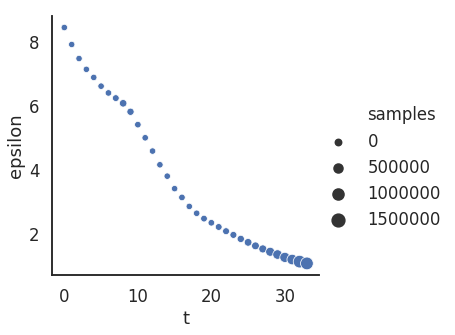

In [34]:
sns.set_context('talk')
evolution = history.get_all_populations()
grid = sns.relplot(x='t', y='epsilon', size='samples', data=evolution[evolution.t>=0])
grid.savefig('results/ikr/eps_evolution.pdf')

In [35]:
df, w = history.get_distribution(m=0)

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()


/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/transition/multivariatenormal.py:64: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self._X_arr = X.as_matrix()


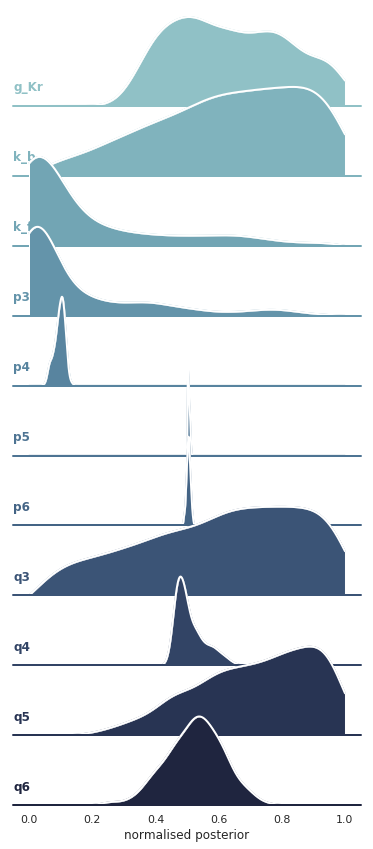

In [43]:
g = plot_parameters_kde(df, w, limits, aspect=5, height=1.1)

In [44]:
g.savefig('results/ikr/parameters_kde.pdf')

# Samples for quantitative analysis

In [37]:
# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/pyabc-0.9.1-py3.6.egg/pyabc/storage/history.py:200: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  w_arr = w.w.as_matrix()


In [38]:
# Generate sim results samples
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    output = model.sample(pars=th, n_x=50)
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


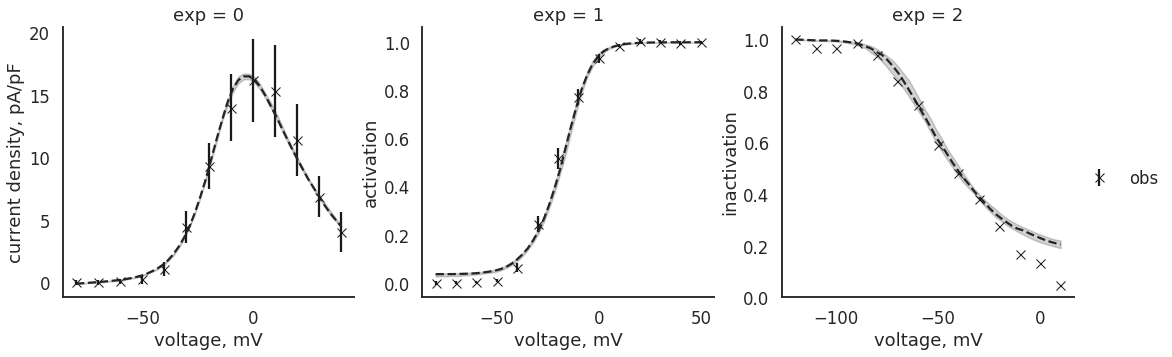

In [40]:
from ionchannelABC import plot_sim_results
sns.set_context('talk')
g = plot_sim_results(samples, obs=measurements)

# Set axis labels
xlabels = ["voltage, mV", "voltage, mV", "voltage, mV", "time, ms"]
ylabels = ["current density, pA/pF", "activation", "inactivation"]
for ax, xl in zip(g.axes.flatten(), xlabels):
    ax.set_xlabel(xl)
for ax, yl in zip(g.axes.flatten(), ylabels):
    ax.set_ylabel(yl)

In [41]:
g.savefig('results/ikr/ikr_sim_results.pdf')

In [45]:
# Activation fit to Boltzmann equation
from scipy.optimize import curve_fit
grouped = samples[samples['exp']==1].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, K):
        return 1/(1+np.exp((Vhalf-V)/K))
    guess = (-30, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [47]:
import scipy.stats as st
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -19.006959674154608
95% CI: (-23.690553929100158, -12.943008619235584)


In [49]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 8.143673554435612
95% CI: (6.999841088430485, 10.64641006169146)


In [54]:
# Inactivation fit to Boltzmann equation
from scipy.optimize import curve_fit
grouped = samples[samples['exp']==2].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, K):
        return 1-1/(1+np.exp((Vhalf-V)/K))
    guess = (-40, 30)
    popt, _ = curve_fit(boltzmann, group.x, group.y)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [58]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -35.41926532865971
95% CI: (-47.62120526011307, -20.219237796670395)


In [59]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 21.09252560793945
95% CI: (15.116458854568313, 32.265251891970216)
